In [45]:
!pip install pandas

In [73]:
#Imports Libraries
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#for word embedding
import gensim
from gensim.models import Word2Vec #Word2Vec is mostly used for huge datasets

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/laurenormand/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/laurenormand/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/laurenormand/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
#Chargement data (train) dans un df et exploration (head)

df_train=pd.read_csv('TextMiningTP/train.csv')
print(df_train.shape)
df_train.head()

(7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


target
0    4342
1    3271
Name: count, dtype: int64


<Axes: >

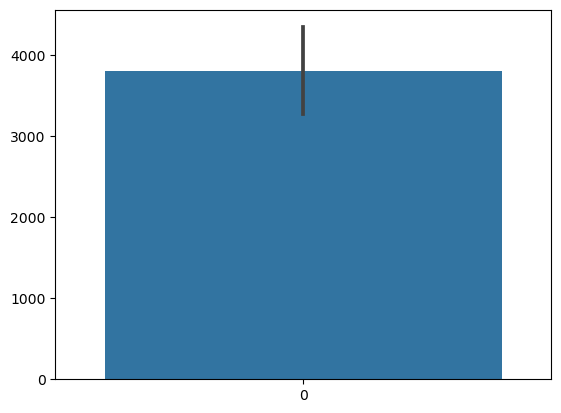

In [25]:
#Visualisation des données en diagramme en baton pour vérifier l'équilibre des données/target
x=df_train['target'].value_counts()
print(x)
sns.barplot(x)

In [27]:
#données manquantes (isna())
df_train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [29]:
#Différence entre les nbs de mots(totaux, uniques), nb caractères, selon la target
#nb de mots
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
print(df_train[df_train['target']==1]['word_count'].mean()) #Disaster tweets
print(df_train[df_train['target']==0]['word_count'].mean()) #Non-Disaster tweets

15.167532864567411
14.704744357438969


In [31]:
#nb de mots uniques
df_train['unique_word_count'] = df_train['text'].apply(lambda x: len(set(str(x).split())))
print(df_train[df_train['target']==1]['unique_word_count'].mean()) #Disaster tweets
print(df_train[df_train['target']==0]['unique_word_count'].mean()) #Non-Disaster tweets

14.664934270865178
14.09649930907416


In [33]:
#nb de caractères
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
print(df_train[df_train['target']==1]['char_count'].mean()) #Disaster tweets
print(df_train[df_train['target']==0]['char_count'].mean()) #Non-Disaster tweets

108.11342097217977
95.70681713496084


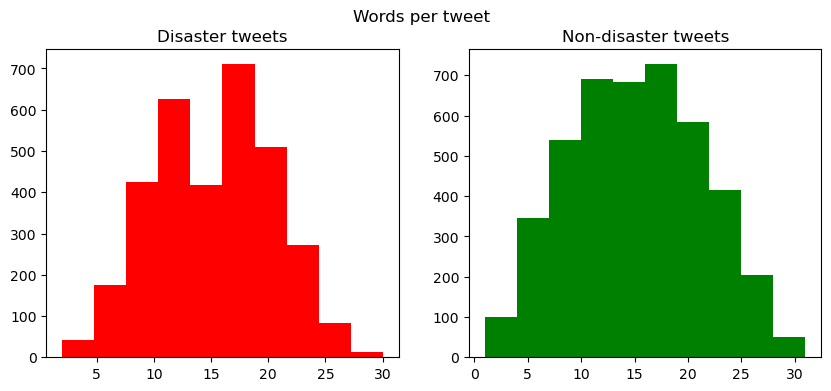

In [35]:
#Visualisation selon nb de mots
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=df_train[df_train['target']==1]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Disaster tweets')
train_words=df_train[df_train['target']==0]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Non-disaster tweets')
fig.suptitle('Words per tweet')
plt.show()

In [53]:
#pd.set_option('display.max_colwidth', -1)
df_train

,id,keyword,location,text,target,word_count,unique_word_count,char_count
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,13,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,7,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,20,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8,8,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,15,88
...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,11,11,83
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,20,17,125
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,8,8,65
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,19,19,137


In [57]:
#Homogénéiser la casse, supprimer les espaces en début et en fin, supprimer la ponctuation, gérer les nombres
text = "   This is a message to be cleaned. It may involve some things like: <br>, ?, :, ''  adjacent spaces and tabs  #test   .  "

#convert to lowercase and remove punctuations and characters and then strip
def preprocess(text):
    text = text.lower() #lowercase text
    text=text.strip()  #get rid of leading/trailing whitespace 
    text=re.compile('<.*?>').sub('', text) #Remove HTML tags/markups
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  #Replace punctuation with space. Careful since punctuation can sometime be useful
    text = re.sub('\s+', ' ', text)  #Remove extra space and tabs
    text = re.sub(r'\[[0-9]*\]',' ',text) #[0-9] matches any digit (0 to 10000...)
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) #matches any digit from 0 to 100000..., \D matches non-digits
    text = re.sub(r'\s+',' ',text) #\s matches any whitespace, \s+ matches multiple whitespace, \S matches non-whitespace 
    
    return text

text=preprocess(text)
print(text)  #text is a string
#Amélioration possible On pourrait extraire les # et créer une nouvelle colonne avec un poids plus important pour la classification

this is a message to be cleaned it may involve some things like adjacent spaces and tabs test


In [61]:
#Stopwords
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

#Lemmatisation
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
# Full list is available here: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [67]:
text = lemmatizer(stopword(text))
print(text)

message clean may involve thing like adjacent space tab test


In [69]:
#2. STEMMING
 
# Initialize the stemmer
snow = SnowballStemmer('english')
def stemming(string):
    a=[snow.stem(i) for i in word_tokenize(string) ]
    return " ".join(a)
text=stemming(text)
print(text)

messag clean may involv thing like adjac space tab test


In [71]:
#FINAL PREPROCESSING
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

df_train['clean_text'] = df_train['text'].apply(lambda x: finalpreprocess(x))
df_train=df_train.drop(columns=['word_count','char_count','unique_word_count'])
df_train.head()

,id,keyword,location,text,target,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order calif...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,get sent photo ruby alaska smoke wildfires pou...


In [79]:
# create Word2vec model
#here words_f should be a list containing words from each document. say 1st row of the list is words from the 1st document/sentence
#length of words_f is number of documents/sentences in your dataset
df_train['clean_text_tok']=[nltk.word_tokenize(i) for i in df_train['clean_text']] #convert preprocessed sentence to tokenized sentence
model = Word2Vec(df_train['clean_text_tok'],min_count=1)  #min_count=1 means word should be present at least across all documents,
#if min_count=2 means if the word is present less than 2 times across all the documents then we shouldn't consider it


w2v = dict(zip(model.wv.index_to_key, model.wv))  #combination of word and its vector

#for converting sentence to vectors/numbers from word vectors result by Word2Vec
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])


In [85]:
#SPLITTING THE TRAINING DATASET INTO TRAINING AND VALIDATION
 
# Input: "reviewText", "rating" and "time"
# Target: "log_votes"
X_train, X_val, y_train, y_val = train_test_split(df_train["clean_text"],
                                                  df_train["target"],
                                                  test_size=0.2,
                                                  shuffle=True)
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  #for word2vec
X_val_tok= [nltk.word_tokenize(i) for i in X_val]      #for word2vec

#TF-IDF
# Convert x_train to vector since model can only run on numbers and not words- Fit and transform
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) #tfidf runs on non-tokenized sentences unlike word2vec
# Only transform x_test (not fit and transform)
X_val_vectors_tfidf = tfidf_vectorizer.transform(X_val) #Don't fit() your TfidfVectorizer to your test data: it will 
#change the word-indexes & weights to match test data. Rather, fit on the training data, then use the same train-data-
#fit model on the test data, to reflect the fact you're analyzing the test data only based on what was learned without 
#it, and the have compatible


#Word2vec
# Fit and transform
modelw = MeanEmbeddingVectorizer(w2v)
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_val_vectors_w2v = modelw.transform(X_val_tok)

In [83]:
#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [87]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)

lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  #model

#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_val_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_val_vectors_tfidf)[:,1]
 

print(classification_report(y_val,y_predict))
print('Confusion Matrix:',confusion_matrix(y_val, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)  

              precision    recall  f1-score   support

           0       0.80      0.81      0.81       859
           1       0.75      0.73      0.74       664

    accuracy                           0.78      1523
   macro avg       0.77      0.77      0.77      1523
weighted avg       0.78      0.78      0.78      1523

Confusion Matrix: [[700 159]
 [180 484]]
AUC: 0.8494668429246672


In [89]:
#FITTING THE CLASSIFICATION MODEL using Naive Bayes(tf-idf)
#It's a probabilistic classifier that makes use of Bayes' Theorem, a rule that uses probability to make predictions based on prior knowledge of conditions that might be related. This algorithm is the most suitable for such large dataset as it considers each feature independently, calculates the probability of each category, and then predicts the category with the highest probability.

nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)  #model

#Predict y value for test dataset
y_predict = nb_tfidf.predict(X_val_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_val_vectors_tfidf)[:,1]
 

print(classification_report(y_val,y_predict))
print('Confusion Matrix:',confusion_matrix(y_val, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)  

              precision    recall  f1-score   support

           0       0.77      0.90      0.83       859
           1       0.84      0.64      0.73       664

    accuracy                           0.79      1523
   macro avg       0.80      0.77      0.78      1523
weighted avg       0.80      0.79      0.78      1523

Confusion Matrix: [[775  84]
 [237 427]]
AUC: 0.8520195450018936


In [91]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression (W2v)
lr_w2v=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_w2v.fit(X_train_vectors_w2v, y_train)  #model

#Predict y value for test dataset
y_predict = lr_w2v.predict(X_val_vectors_w2v)
y_prob = lr_w2v.predict_proba(X_val_vectors_w2v)[:,1]
 

print(classification_report(y_val,y_predict))
print('Confusion Matrix:',confusion_matrix(y_val, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)  

              precision    recall  f1-score   support

           0       0.64      0.82      0.72       859
           1       0.64      0.41      0.50       664

    accuracy                           0.64      1523
   macro avg       0.64      0.62      0.61      1523
weighted avg       0.64      0.64      0.63      1523

Confusion Matrix: [[708 151]
 [393 271]]
AUC: 0.6989766399708263
